# Monte Carlo

## Objectives

* Work through two examples using MC
    * Random walk
    * Nuclear decay

Monte Carlo (MC) methods are a subset of computational algorithms that use the process of repeated random sampling to make numerical estimations of unknown parameters. They allow for the modeling of complex situations where many random variables are involved, and assessing the impact of risk. Used in many different fields as in finance, economy models, hydrology, etc. It was originalll proposed by S.Ulam during the Manhattan project.

In [1]:
%matplotlib notebook

<font color="red">

> Warning: if you try to run the cell following an interactive Matplotlib plot very quickly, Jupyter might not actually run the cell. Just try again.

</font>

Standard imports

In [2]:
import matplotlib.pyplot as plt
import time
import numpy as np

## Random walk

Example in book, but without VPython.

We first will need to set up a plot. Since we are using an interactive backend for Matplotlib, we need to set up the plot first. We'll plot on point in the center. We'll also set (and not update) the plot limits.

<IPython.core.display.Javascript object>


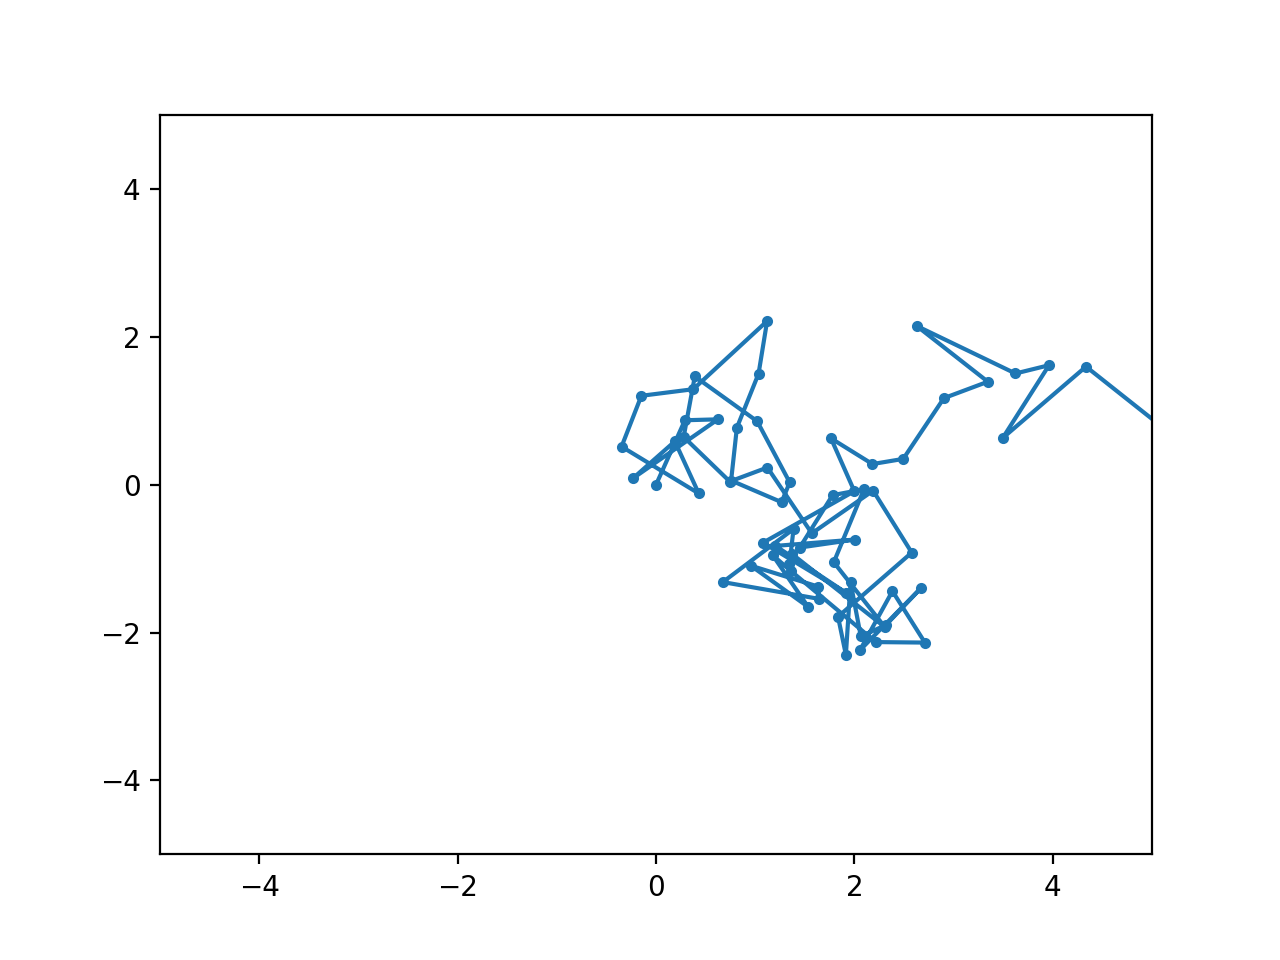

In [3]:
fig, ax = plt.subplots()
(line,) = plt.plot([0], [0], ".-")
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
plt.show()

Now, we loop and generate random numbers for the walk. We are currently ignoring the step length (it will not be exactly one). We'll also simply get the current plot arrays, make new arrays with one extra point, then put them in. A small sleep parameter will help the plot be slow enough to see.

In [4]:
jmax = 100
x = 0.0
y = 0.0

for i in range(jmax + 1):
    # x = x + (np.random.random() - 0.5) * 2
    x += (np.random.random() - 0.5) * 2
    y += (np.random.random() - 0.5) * 2
    xs, ys = line.get_data()
    xs = np.append(xs, [x])
    ys = np.append(ys, [y])
    line.set_data(xs, ys)
    fig.canvas.draw()
    time.sleep(0.1)

In [7]:
# <r^2> = sqrt((xi-x0)^0+(yi-y0^2))
# <r^2> ~ t^a   this is true if the particles are from a Gaussian distribution.
# a = 1.0 diffusive
# a > 1.0  superdiffusive
# a < 1.0   underdiffuse

print("r actual =", np.sqrt(x ** 2 + y ** 2))
print("r expected =", np.sqrt(jmax) * 0.75)

r actual = 8.319487320922086
r expected = 7.5


Exercises:
* Modify the code so that the step length is one.
* Modify the code so that the edges of the plot change. Use `np.min` and `np.max` (and maybe add a small scaling factor so keep the plot from touching the edges).

Let's try again, but this time using numpy syntax to avoid the explicit loop. We'll add the radius correction here.

<IPython.core.display.Javascript object>


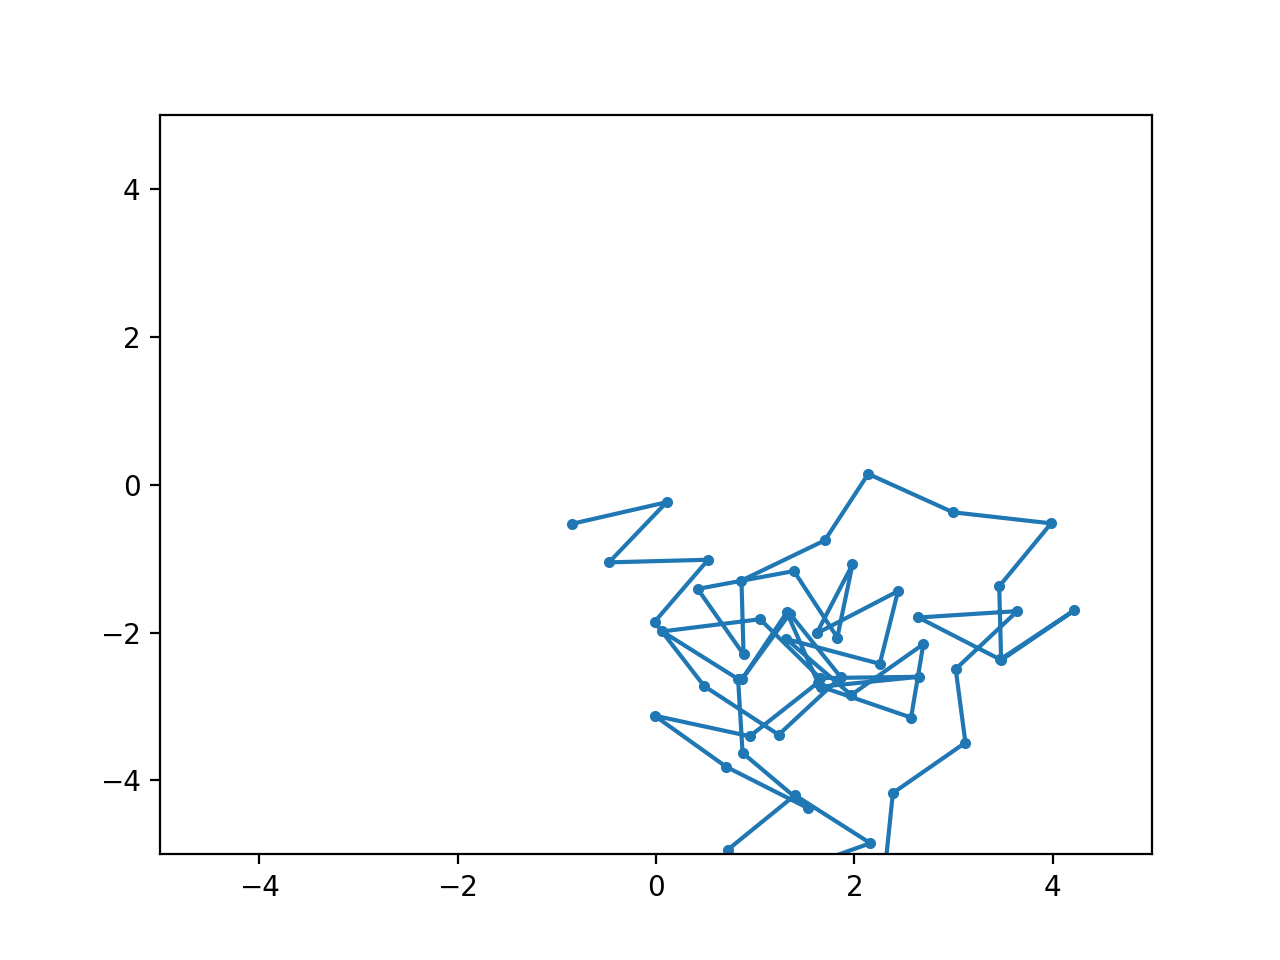

In [5]:
fig, ax = plt.subplots()
(line,) = plt.plot([0], [0], ".-")
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
plt.show()

In [6]:
def rwalk(size):
    # xs=[n1x,n2x,n3,n4...]
    # ys=[n1y,n2y,n3,n4...]
    #     n1x**2+n1y**2,
    xs = (np.random.random(size) - 0.5) * 2
    ys = (np.random.random(size) - 0.5) * 2

    r = np.sqrt(xs ** 2 + ys ** 2)
    xs /= r
    ys /= r
    # xs = [x0,x1,x3,]

    # cumulative sum. [n0, n0+n1, n0+n1+n2, ...]
    # x0,x1,x2,...
    # xloc=[x0,x0+x1,x0+x1+x2,...]
    xloc = np.cumsum(xs)
    yloc = np.cumsum(ys)

    return xloc, yloc

In [7]:
xloc, yloc = rwalk(jmax)
for i in range(jmax):
    line.set_data(xloc[:i], yloc[:i])
    fig.canvas.draw()
    time.sleep(0.1)

Exercises:

* Change this to use a single 2D array, of shape `(2,N)`, where `array[0]` is x and `array[1]` is y. You'll need to specify an axis for the cumsum operation.

We'll plot five of these random walks. Let's rely on Matplotlib's color cycling to keep this clear. We'll use the `*` to expand the two items returned from the `rwalk` into the two items expected by `plot`.

<IPython.core.display.Javascript object>


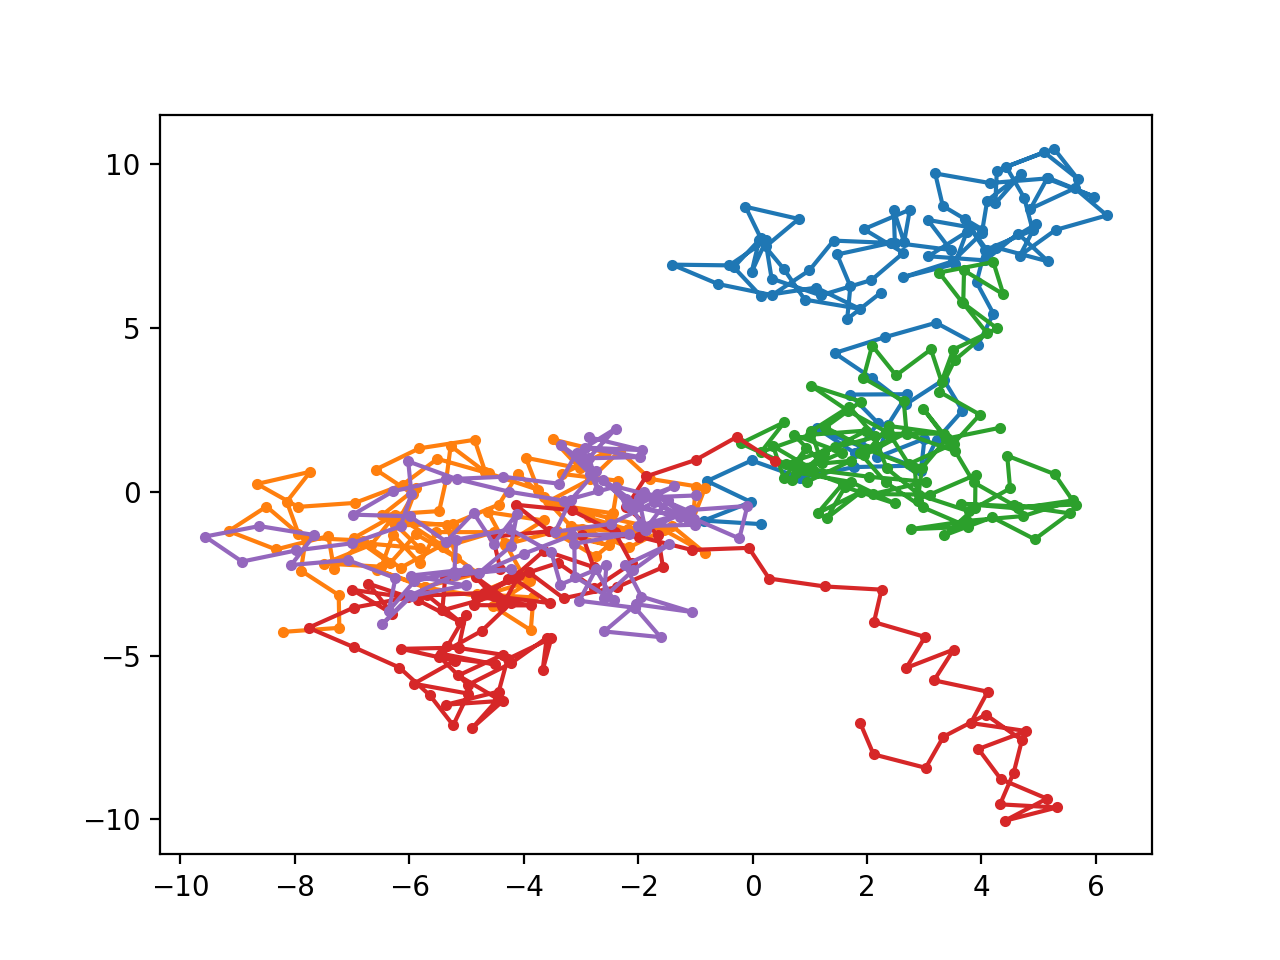

In [8]:
fig, ax = plt.subplots()
for i in range(5):
    # plt.plot(x,y)
    plt.plot(*rwalk(jmax), ".-")
    # x,y=rwalk(jmax)
    # plt.plot(x,y,".-")

plt.show()

Let's redo that function and just compute the final sum - we'll then compute the radius and return that.

In [10]:
def rwalksum(size):
    
    xs = (np.random.random(size) - 0.5) * 2
    ys = (np.random.random(size) - 0.5) * 2

    r = np.sqrt(xs ** 2 + ys ** 2)
    xs /= r
    ys /= r

    xloc = np.sum(xs)
    yloc = np.sum(ys)

    return np.sqrt(xloc ** 2 + yloc ** 2)

Now, we'll fill in 100,000 entries of an empty array with the values from 100,000 trials.

In [11]:
vals = np.empty(100_000, dtype=np.float64)
for i in range(len(vals)):
    vals[i] = rwalksum(jmax)

Now, let's make a histogram. Letting Matplotlib (really Numpy under the hood) pick the binning is fine:

<IPython.core.display.Javascript object>


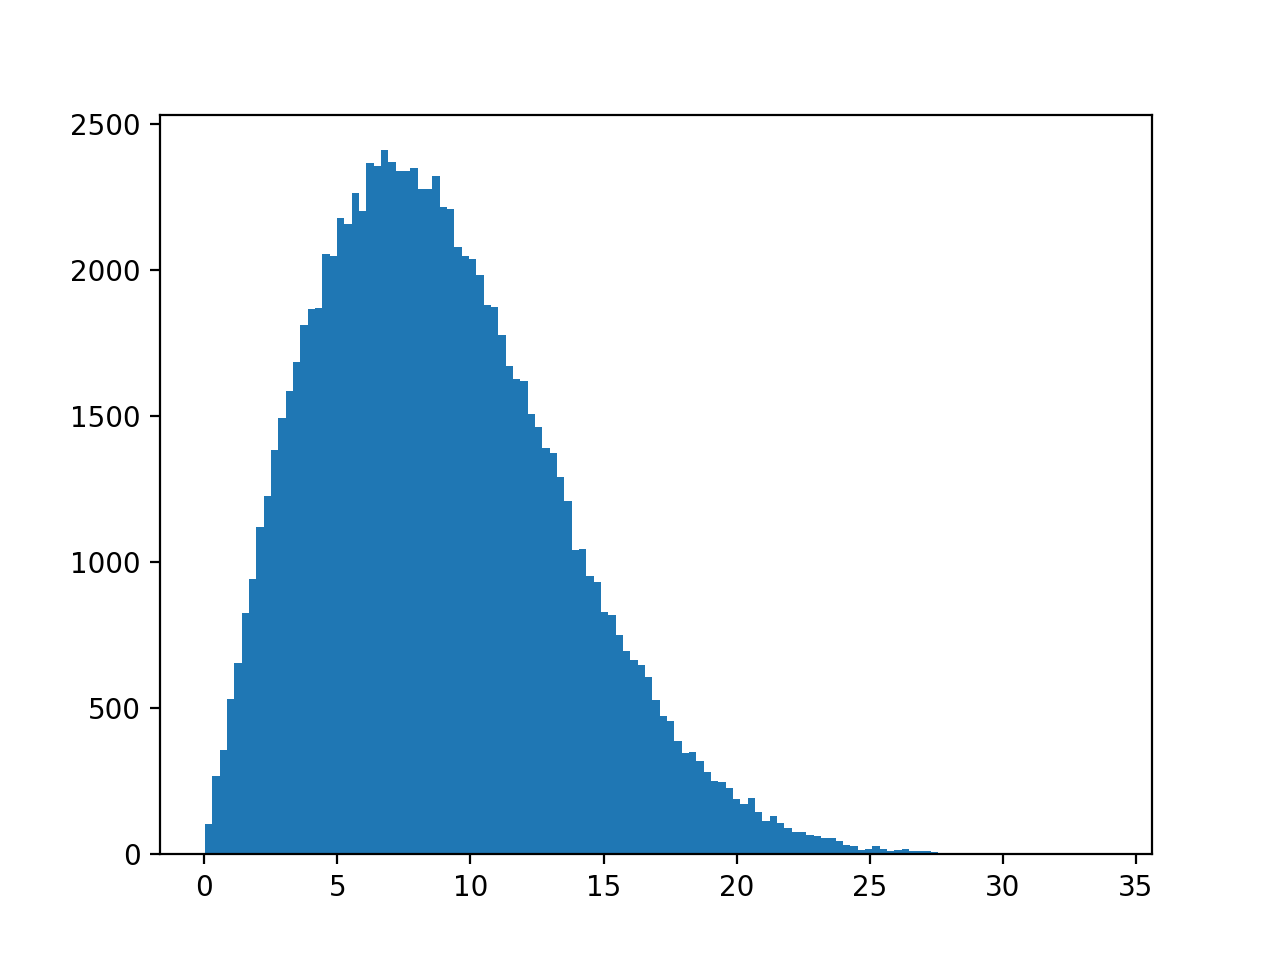

In [12]:
fig, ax = plt.subplots()
ax.hist(vals, bins="auto")
plt.show()

In [16]:
np.mean(vals)

8.876282353993725

## Radioactive decay

Now, let's look at radioactive decay:

This process occur when an atomic nuclei do not have enough binding energy to keep the nuclei together. In this process, there are several conservation laws: charge, number of nucleons, mass/energy, linear and angular momentum. There are usually three types of decays

+ Alpha decay: identically to the Hellium nucleus (two protons and two neutrons). The parent particle decreases atomic number by two.
+ Beta decay: A neutron decays into a proton, an electron and antineutrino or a proton decays in a neutron, positron and a neutrino.
+ Gamma decay: After alpha or beta decay, the nucleus leaves in an excited state with energy excess. There is a decay and a photon is created. 

One of the properties of interest is to find the half-life, the time required for a half particle to decay (half of the sample will decay). 

We want to simulate how N particles decay and here we assume that the decay is exponential. 

$N(t) = N_0 \exp(-\lambda t)$

In [14]:
particles = 1000
decay_prob = 0.001
decays = []  # list of decay times

for time in range(500):
    for particle in range(particles):
        # create a random event
        decay = np.random.random()
        # if the random event follows the constraint, then
        if decay < decay_prob:
            particles -= 1
            decays.append(time)

Note: The law of particle decays say that $N_0 exp(-\lambda t)$. Therefore the probability that a particle will not decay in a time interval t would be $P1(t) = N(t)/N(0) = exp(-\lambda t)$. Therefore the probability that a particle will decay would be $P2(t) = 1 - P1(t)$. The actual method then would be

+ Give N0 and $\lambda$
+ Define the time $t$
+ Generate a random number
+ compare random number $x \ge exp(-\lambda t)$.

<IPython.core.display.Javascript object>


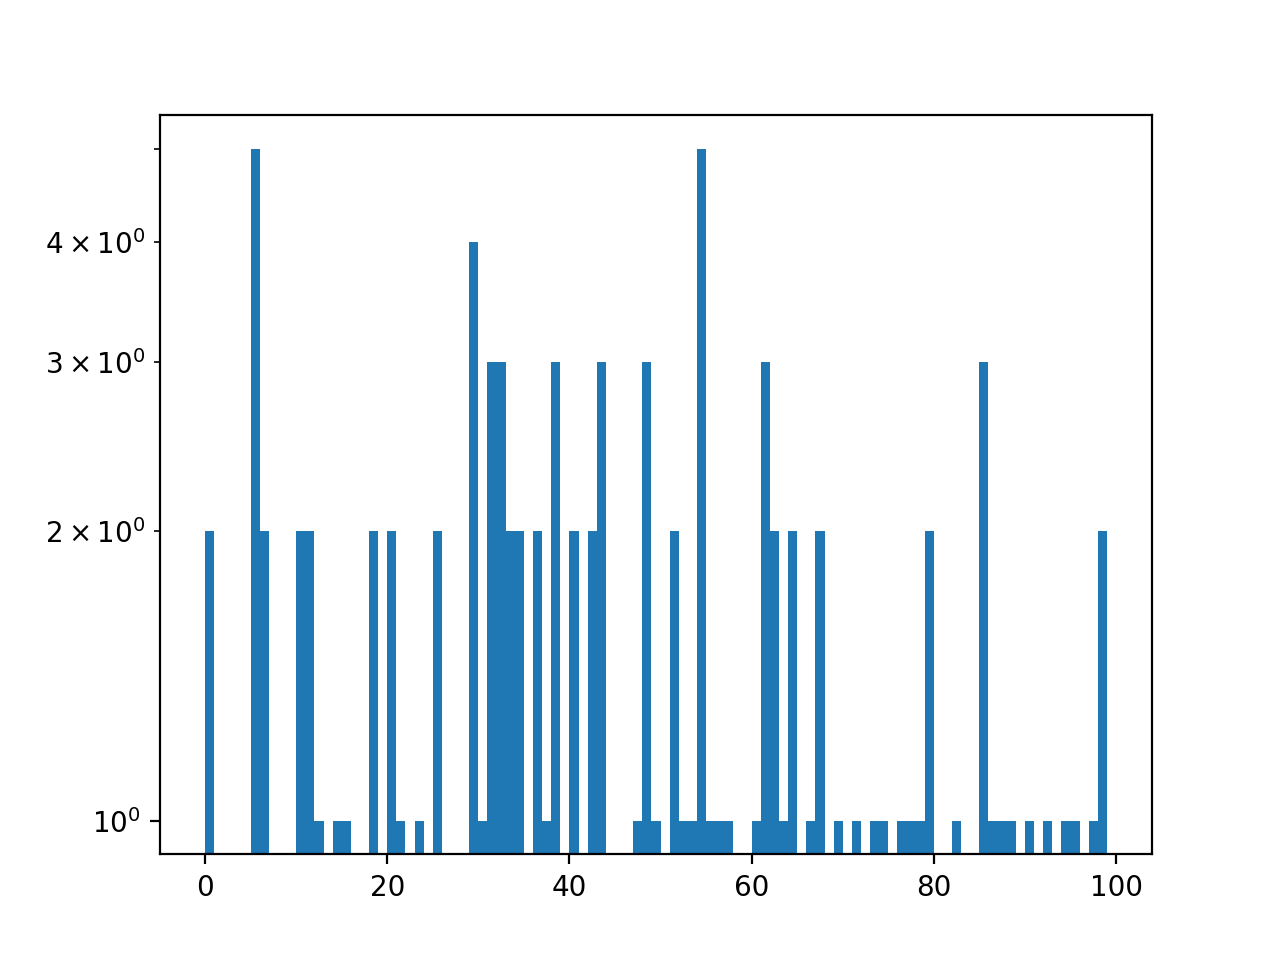

In [15]:
fig, ax = plt.subplots()
ax.hist(decays, bins=range(100))
ax.set_yscale('log') # Uncomment if you have lots of particles
plt.show()

We can build a sound array and play it:

In [16]:
from IPython.display import Audio

We will use the norm from scipy instead of manually computing a gaussian.

In [17]:
from scipy.stats import norm

In [18]:
ar = np.linspace(-10, 10, 100)
g = norm(0, 3).pdf(ar) * np.sin(ar * 4)

Let's look at our little sound.

<IPython.core.display.Javascript object>


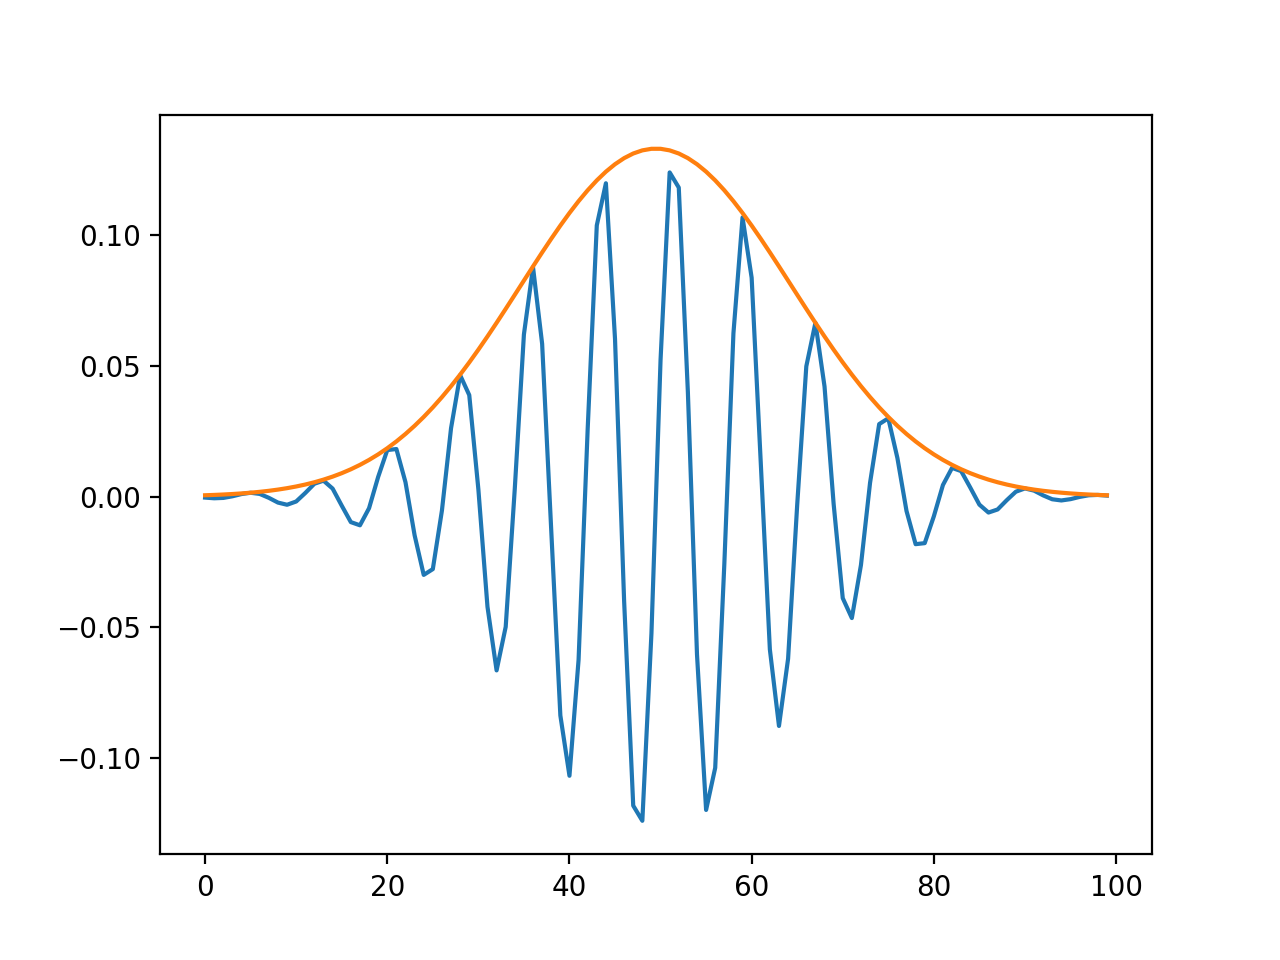

In [19]:
plt.figure()
plt.plot(g)
plt.plot(norm(0, 3).pdf(ar))
plt.show()

We'll spread this out into 100 values per time bin, then we'll convolve this sound shape with each values (these act like delta functions).

In [20]:
d = np.histogram(np.array(decays) * 100, bins=range(50000))[0]
d = np.convolve(d, g)
d = d / d.sum()

Audio(data=d, rate=3000)

Let's look at one of these decays, just to make sure our convolution worked.

<IPython.core.display.Javascript object>


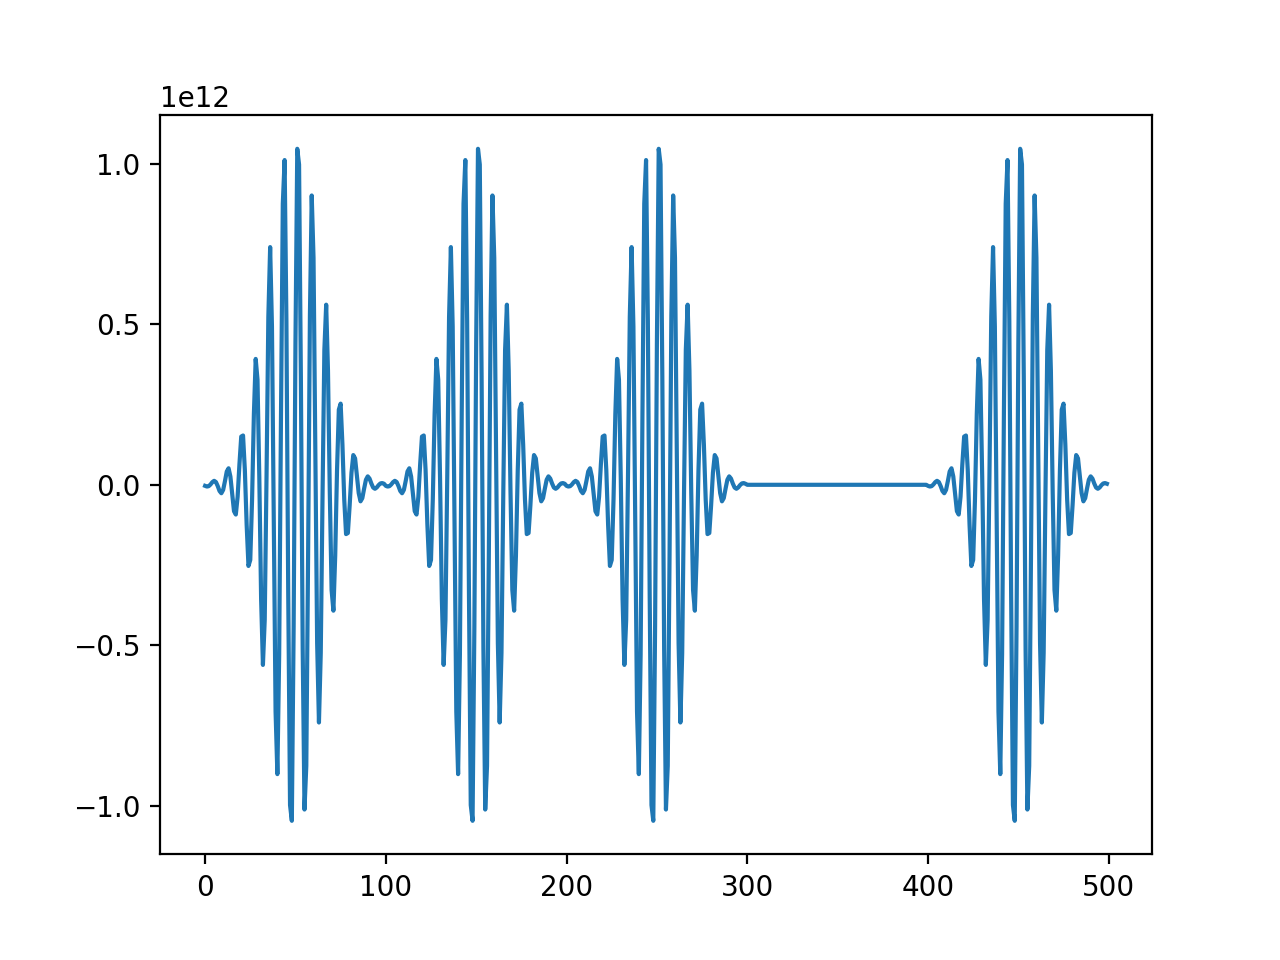

In [33]:
plt.figure()
plt.plot(d[: decays[0] * 100 + 500])
plt.show()